## Table of content:
* [Space filling curve](#first-bullet)
* [Convolutional autoencoder](#second-bullet)

# Import Required Libraries 

In [11]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [12]:
import os
os.chdir('/content/gdrive/MyDrive/dimension reduction')

In [13]:
!pip install vtk

In [14]:
!pip install cmocean

mesh = meshio.read(filename,  # string, os.PathLike, or a buffer/open file

file_format="stl",  # optional if filename is a path; inferred from extension

mesh.points, mesh.cells, mesh.cells_dict, ...

In [15]:
! pip install meshio

In [16]:
!python -m numpy.f2py -c space_filling_decomp_new.f90 -m space_filling_decomp_new

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "space_filling_decomp_new" sources
f2py options: []
f2py:> /tmp/tmptbi_uvx6/src.linux-x86_64-3.7/space_filling_decomp_newmodule.c
creating /tmp/tmptbi_uvx6/src.linux-x86_64-3.7
Reading fortran codes...
	Reading file 'space_filling_decomp_new.f90' (format:fix)
Line #19 in space_filling_decomp_new.f90:"          PARAMETER(DISC=.TRUE.) "
	determineexprtype: could not determine expressions ('.true.') type.
analyzeline: Failed to evaluate '.true.'. Ignoring: invalid syntax (<string>, line 1)
Line #943 in space_filling_decomp_new.f90:"          parameter( weights_from_curve_no=.true. )  "
	determineexprtype: could not determine expressions ('.true.') type.
analyzeline: Failed to evaluate '.true.'. Ignoring: invalid syntax (<string

In [17]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Imports same as https://github.com/viluiz/gan/blob/master/DA-PredGAN/1.Compress_train.ipynb

In [18]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import os
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import gzip
import vtk
import vtktools

import space_filling_decomp_new as sfc
import sys, os
import datetime, time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

import platform

import glob
import progressbar
import meshio
import cmocean
import joblib

# Space filling curve  <a name='first-bullet'></a>

Space filling curves are one-dimensional(1D) orederings which traverse every single data in the multi-dimensional space one time, and it reorders data in multi-dimensional space that maps to 1D space.

In [ ]:
# comment this to enable interactive mode
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os

matplotlib.use('AGG')

def apply_rules(s):
  """ Hilbert Curve as a Lindenmayer system (L-system)
  https://en.wikipedia.org/wiki/Hilbert_curve#Representation_as_Lindenmayer_system"""
  s=s.replace("a","-Bf+AfA+fB-")  # capital letters "A" and "B" so that the second operation
  s=s.replace("b","+Af-BfB-fA+")  # doesn't apply to the changes already made
  return s.lower() # make everyone lowercase

axiom = "a"
n=3 # number of iterations
# displacements, ordered in a counter-clockwise direction
dxdy = np.array([[1, 0],    # right
          [0, 1],    # up
          [-1, 0],    # left
          [0, -1]])  # down
# displacement is of size 1, so the higher n is, the greater the domain
length = 2**n-1; margin = 0.05*length
domain = [0-margin,length+margin,0-margin,length+margin] # a 5% margin around the curve
s = axiom # string to iterate upon

for i in np.arange(n):
  s = apply_rules(s)

make_movie=True
plt.ion() # interactive mode disabled if "matplotlib.use('AGG')"
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')                        # no frame
ax.axis(domain)                       # domain size
ax.set_aspect('equal')                # square look
ax.set_xticks([]); ax.set_yticks([])  # no ticks
ax.set_title(r"$n = {:d}$".format(n))
plt.show()

# "a" and "b" can be erased now
s=s.replace("a","")
s=s.replace("b","")

frame_names = []  # these two are only relevant if make_movie==True
frame_counter=0

p = np.array([[0.0,0.0]]) # this is the starting point (0,0)
p_plot, = plt.plot(p[:,0],p[:,1],color="black")

# iterate on the string s
for i,c in enumerate(s):
  # uncomment to see how fast things are going
  # print("{:d}/{:d}".format(i,len(s)))
  
  # rotations "+" and "-" change the displacement array dxdy
  # "+" means clockwise rotation
  if c == '+': dxdy = np.roll(dxdy,+1,axis=0)
  # "-" means counter-clockwise rotation
  if c == '-': dxdy = np.roll(dxdy,-1,axis=0)
  # forward "f"
  if c == 'f':
    # add one more point to array p
    p = np.vstack([p, [p[-1,0]+dxdy[0,0],p[-1,1]+dxdy[0,1]] ])
    # update p_plot data, this is MUCH faster that plotting
    # several line segments separately
    p_plot.set_data(p[:,0],p[:,1])
    fig.canvas.draw()
    if make_movie:
      fname = "_tmp{:05d}.png".format(frame_counter)
      frame_names.append(fname)
      fig.savefig(fname,bbox_inches='tight',resolution=300)
    frame_counter += 1

if make_movie:
  frames = "_tmp%5d.png"
  # movie_command = "mencoder mf://*.png -mf fps=24:type=png --ovc lavc -lavcopts vcodec=mpeg4:mbd=2:trell -oac copy -o hil{:d}.avi".format(n)
  
  # we might have other .png figures in the directory
  # in this case, use the code below
  f = open("png_list.txt", "w")
  for i in frame_names:
      f.write(i+"\n")
  f.close()
  movie_command = "mencoder mf://@png_list.txt -mf fps=24:type=png -ovc lavc -lavcopts vcodec=mpeg4:mbd=2:trell -oac copy -o hil{:d}.avi".format(n)
  
  err=os.system(movie_command)
  if err!=0:
      raise RuntimeError("Couldn't run mencoder.  Data in tmp*.png files")
  for fname in frame_names:
      os.remove(fname)       

## Load vtu and calculate space filling curve numbering

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# calculate the space-filling curve for the mesh and convert to csv format

#----------------------------------------------------------------------------------------------
# DG example
#path = 'data/FPC_Re3900_DG_old/'
#filename = path + 'Flowpast_2d_Re3900_0.vtu' # this file will do (all files have the same mesh)
#mesh_type = 'DG' # 'DG' or 'CG' (likely to be DG if nNodes (nPoints in Paraview) is an integer multiple (3 or 4) or nElements (nCells in Paraview))
#nTotalExamples = 400 # maximum is 1000 for this data set

# CG example
#path = 'data/FPC_Re3900_CG_new/'
path = 'ClarenceData/'
filebase = 'ClarenceCentre_'
#filebase = 'fpc_'
filename = path + filebase + '0.vtu' # this file will do (all files have the same mesh)
mesh_type = 'CG' # 'DG' or 'CG' (likely to be DG if nNodes (nPoints in Paraview) is an integer multiple (3 or 4) or nElements (nCells in Paraview))
nTotalExamples = 250 # maximum is 1000 for this data set
#----------------------------------------------------------------------------------------------

# ************************************************************************************************

print(filename)
vtu_data = vtktools.vtu(filename)
coords = vtu_data.GetLocations()
nNodes = coords.shape[0]

print('coords: ', coords)
    
# form node connectivity
if mesh_type == 'DG':   
  findm,colm,ncolm = sfc.form_spare_matric_from_pts( coords, nNodes )
  colm = np.ones((ncolm),dtype = 'int')
  colm = colm[0:ncolm]
elif mesh_type == 'CG':
  ncolm=0
  colm=[]
  findm=[0]
  for nod in range(nNodes):
    nodes = vtu_data.GetPointPoints(nod)
    nodes2 = np.sort(nodes) #sort_assed(nodes) 
    colm.extend(nodes2[:]) 
    nlength = nodes2.shape[0]
    ncolm=ncolm+nlength
    findm.append(ncolm)

  colm = np.array(colm)
  colm = colm + 1
  findm = np.array(findm)
  findm = findm + 1

# sfc settings
ncurve = 2
graph_trim = -10  # has always been set at -10
starting_node = 0 # =0 do not specifiy a starting node, otherwise, specify the starting node
        
# call the sfc fortran code (space_filling_decomp_new.so)
whichd, space_filling_curve_numbering = sfc.ncurve_python_subdomain_space_filling_curve(colm, findm, starting_node, graph_trim, ncurve, nNodes, ncolm)

N = len(space_filling_curve_numbering)
inverse_numbering = np.zeros((N, ncurve), dtype=np.int)

# fortran numbers from 1 to N :-) whereas python numbers from 0 to N-1
space_filling_curve_numbering = space_filling_curve_numbering - 1
    
inverse_numbering[:, 0] = np.argsort(space_filling_curve_numbering[:, 0])
inverse_numbering[:, 1] = np.argsort(space_filling_curve_numbering[:, 1])
print('0: ',len(inverse_numbering[:, 0]))
print('1: ',len(inverse_numbering[:, 1]))
for i in range(ncurve):
  print('sfc number',i+1)
  print('min and max of sfc numbering', np.min(inverse_numbering[:,i]), np.max(inverse_numbering[:,i]) )
  print('min and max of inverse sfc numbering', np.min(space_filling_curve_numbering[:,i]), np.max(space_filling_curve_numbering[:,i]) )
    
# read in data and save, with sfc ordering, to csv file   

t_save_to_csv = 0
t_read_in = 0

#cwd = os.getcwd()
if not os.path.isdir('csv_data'):
  os.mkdir('csv_data')  
#os.chdir('csv_data') # will overwrite files in results



ClarenceData/ClarenceCentre_0.vtu
coords:  [[222.480167    66.89271647   6.82801072]
 [222.36562311  66.82780997   6.78431655]
 [222.46025387  66.82849167   6.88385937]
 ...
 [221.53716624  66.59689681   7.82428816]
 [221.70132513  67.04791967   7.72115983]
 [221.67527295  66.97634189   7.7589538 ]]
0:  148906
1:  148906
sfc number 1
min and max of sfc numbering 0 148905
min and max of inverse sfc numbering 0 148905
sfc number 2
min and max of sfc numbering 0 148905
min and max of inverse sfc numbering 0 148905


## save CO2 data to CSV file

In [ ]:
nTotalExamples = 250
for data_i in range(nTotalExamples):

  t0 = time.time()    
  filename = path + filebase + str(data_i) + '.vtu'
  vtu_data = vtktools.vtu(filename)
  # D[:,0] and D[:,1] store order1 and order2, D[:,2] store velocity

  t1 = time.time()
  t_read_in = t_read_in + t1 - t0

  
  D = np.zeros((nNodes, 4))

  D[:, :2] = inverse_numbering # this seems to be transformed to reals - should be integers

  C02_data = vtu_data.GetField('CO2_ppm')
  #D[:, 2] = np.sqrt(velocity[:nNodes, 0]**2 + velocity[:nNodes, 1]**2) # not needed
  D[:, 3] = C02_data[:nNodes, 0]

  t0 = time.time()
  np.savetxt('csv_data/data_' + str(data_i) + '.csv', D , delimiter=',')
  t1 = time.time()
  t_save_to_csv = t_save_to_csv + t1 - t0

  if data_i%100==0:
    print("data loaded", data_i)

print('Time loading data',t_read_in,'s')
#print('Time to write to csv', t_save_to_csv, 's')
# Flowpast_2d_Re3900_0

data loaded 0
data loaded 100
data loaded 200
Time loading data 684.4338202476501 s


## Transform to training, validation and test set

In [ ]:
#os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
print(os.getcwd())

# t_read_0 = time.time()

# read in the data (1000 csv files)
nTrain = 200
nValid = 25
nTest = 25
nTotal = nTrain + nValid + nTest
nNodes = 148906 # should really work this out

# [:, :, 2] is speed, [:, :, 3] is u, [:, :, 4] is v
# (speed not really needed)
# [:, :, 0] and [:, :, 1] are the SFC orderings

training_data = np.zeros((nTrain,nNodes,4))
for i in range(nTrain):
    data = np.loadtxt('csv_data/data_' +str(i)+ '.csv', delimiter=',')
    training_data[i,:,:] = data
training_data = np.array(training_data)
print('size training data', training_data.shape)

valid_data = np.zeros((nValid,nNodes,4))
for i in range(nTrain,nTrain+nValid):
    data = np.loadtxt('csv_data/data_' +str(i)+ '.csv', delimiter=',')
    valid_data[i-nTrain,:,:] = data
valid_data = np.array(valid_data)
print('size validation data', valid_data.shape)

test_data = np.zeros((nTest,nNodes,4))
for i in range(nTrain+nValid,nTrain+nValid+nTest):
    data = np.loadtxt('csv_data/data_' +str(i)+ '.csv', delimiter=',')
    test_data[i-nTrain-nValid,:,:] = data
test_data = np.array(test_data)
print('size test data', test_data.shape)

# t_read_1 = time.time()


/content/gdrive/My Drive/dimension reduction
size training data (200, 148906, 4)
size validation data (25, 148906, 4)
size test data (25, 148906, 4)


## Standardlisation

In [90]:
# training_data = np.array(training_data)

ma = np.max(training_data[:, :, 3])
mi = np.min(training_data[:, :, 3])
ku = 2/(ma - mi)
bu = 1 - k*ma
training_data[:, :, 3] = ku * training_data[:, :, 3] + bu
valid_data[:, :, 3] = ku * valid_data[:, :, 3] + bu


In [ ]:
np.savetxt('coords.csv', coords, delimiter=',')
coords = np.loadtxt('coords.csv', delimiter=',')
#np.allclose(coords_load,coords)
coords_vtu = coords

## Another way of loading and saving vtu file

In [ ]:
def loadvtufile(path, name_simu, fieldname, vtu_start, vtu_end, vtu_step):
    """
    Read in .vtu files for a particular field
    
    Parameters
    ----------
    path : str 
        path to the folder containing the .vtu files
    name_simu : str
        name of the simulation data
    field_name : str
        field to read in e.g. CO2_ppm 
    vtu_start : int
        file number to start reading from  
    vtu_end : int
        file number to read up to
    vtu_step : int
        how many files to step across
    Returns
    -------
    numpy.ndarray 
        Returns the data from a particular field 
    """
    tic = time.time()
    
    extension = '.vtu'
    
    all_data = []

    #---------------------------------------------------------------------
    # EXTRACT DATA
    #---------------------------------------------------------------------
    for vtuID in range(vtu_start,vtu_end + 1,vtu_step):
        filename=path+name_simu+'_'+str(vtuID)+extension
        print ('\n  '+str(filename))

        vtu_data = vtktools.vtu(filename)
        data     = vtu_data.GetField(fieldname)
        #print (data)
        all_data.append(data)


    toc = time.time() #added 
    print ('\n\nTime : ', toc - tic, 'sec')
    return np.array(all_data)

In [ ]:
path = '/content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/'
name_simu = 'fpc'
vtu_start = 0
vtu_end   = 10
vtu_step  = 1

#P = loadvtufile(path, name_simu, 'CO2_ppm', vtu_start, vtu_end, vtu_step)
U = loadvtufile(path, name_simu, 'Velocity', vtu_start, vtu_end, vtu_step)


  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_0.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_1.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_2.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_3.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_4.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_5.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_6.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_7.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/fpc_8.vtu

  /content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/

## Plot structured data

In [ ]:
def read_in_files(data_path, file_format='vtu', vtu_fields=None):
    # Return a possibly-empty list of path names that match pathname, which must be a string containing a path specification.
    data = glob.glob(data_path + "*")  # data is the 
    # print('\t')
    print('data: ',data)
    print('data[0]: ',data[0].split('.'))
    print('data[0].split('')[-1]:',data[0].split('.')[-1])
    print('data[0].split('')[-2]:',data[0].split('.')[-2])
    # print('\t')
    num_data = len(data)-1
    print('how many vtu file: ',num_data)

    #file_prefix = data[0].split('.')[-2].split('_')
    file_prefix = data[0].split('.')[-2].split('_')
    #print('file_prefix: ',file_prefix)
    #file_prefix:  ['data/FPC', 'Re3900', 'DG', 'old/Flowpast', '2d', 'Re3900', '472']
    file_prefix.pop(-1)
    #print('print(file_prefix)1:',file_prefix)
    #file_prefix: data/FPC_Re3900_DG_old/Flowpast_2d_Re3900_, file_format: .vtu

    if len(file_prefix) != 1: file_prefix = '_'.join(file_prefix) + "_"
    else: file_prefix = file_prefix[0] + "_"
    # file_format = data[0].split('.')[-1]
    file_format = '.' + file_format
    print('file_prefix: %s, file_format: %s' % (file_prefix, file_format))
    cnt_progress = 0
    if (file_format == ".vtu"):
      print("Read in vtu Data......\n")
      bar=progressbar.ProgressBar(maxval=num_data)
      #print('what is bar',bar.start())
      # """Starts measuring time, and prints the bar at 0%.
      bar.start()
      data = []
      coords = None
      cells = None
      start = 0
      while(True):
        if not os.path.exists(F'{file_prefix}%d{file_format}' % start):
          print(F'{file_prefix}%d{file_format} not exist, starting number switch to {file_prefix}%d{file_format}' % (start, start+1))
          start += 1
        else: break
      for i in range(start, num_data + start):
        data.append([])
        
        # """Reads an unstructured mesh with added data.
        # :returns mesh{2,3}d: The mesh data.
        vtu_file = meshio.read(F'{file_prefix}%d{file_format}' % i)
        # print('vtu_fiel: ',vtu_file)
        if not (coords == vtu_file.points).all():
          
          # points, cells_dict are the instance of the object in the class defined in the meshio lib
          coords = vtu_file.points
         # print('coords',coords)
          cells = vtu_file.cells_dict
          print('mesh adapted at snapshot %d' % i)
        for j in range(len(vtu_fields)):
          vtu_field = vtu_fields[j]
          
          if not vtu_field in vtu_file.point_data.keys():
            raise ValueError(F'{vtu_field} not avaliable in {vtu_file.point_data.keys()} for {file_prefix} %d {file_format}' % i)
          field = vtu_file.point_data[vtu_field]
          if field.ndim > 1 and field[..., -1].max() - field[..., -1].min() < 1e-8: field = field[...,0:-1] # get rid of zero coords
          if j == 0:
            if field.ndim == 1: field = field.reshape(field.shape[0], 1)
            data[i - start] = field
          else:
            if field.ndim == 1: field = field.reshape(field.shape[0], 1)
            data[i - start] = np.hstack((data[i - start], field))
        # print(data[i - start].shape)
        cnt_progress +=1
        bar.update(cnt_progress)
      # """Puts the ProgressBar bar in the finished state."""
      bar.finish()
      whole_data = torch.from_numpy(np.array(data)).float()
      # if whole_data[..., whole_data.ndim - 1].max() - whole_data[..., whole_data.ndim - 1].min() < 1e-6: 
      #     whole_data = whole_data[..., :whole_data.ndim - 1]
      # if coords[..., -1].max() - coords[..., -1].min() < 1e-6: coords = coords[..., :-1]
      # print(F'{vtu_field} has %d dimensions.'% whole_data.ndim)
      #
      #return whole_data, coords, cells
      return whole_data,coords 

# DG data
#data_path = 'SFC-CAE/data/FPC_Re3900_DG_old/'
#data_path = 'SFC-CAE/SFC-CAE-main/data/FPC_Re3900_CG_new/'
data_path = 'ClarenceData/'
#vtu_fields = ['Velocity']
vtu_fields = ['CO2_ppm']
# """Returns an array with the locations of the nodes as coords_vtu."""
full_tensor, coords_vtu = read_in_files(data_path, vtu_fields = vtu_fields)
#full_tensor, coords, cells = read_in_files(data_path, vtu_fields = vtu_fields)
# print('full_tensor: ', full_tensor) 
# print('cell: ', cells)
print(full_tensor,full_tensor.shape)

N/A% (0 of 455) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

data:  ['ClarenceData/ClarenceCentre_0.vtu', 'ClarenceData/ClarenceCentre_1.vtu', 'ClarenceData/ClarenceCentre_2.vtu', 'ClarenceData/ClarenceCentre_3.vtu', 'ClarenceData/ClarenceCentre_4.vtu', 'ClarenceData/ClarenceCentre_5.vtu', 'ClarenceData/ClarenceCentre_6.vtu', 'ClarenceData/ClarenceCentre_7.vtu', 'ClarenceData/ClarenceCentre_8.vtu', 'ClarenceData/ClarenceCentre_9.vtu', 'ClarenceData/ClarenceCentre_10.vtu', 'ClarenceData/ClarenceCentre_11.vtu', 'ClarenceData/ClarenceCentre_12.vtu', 'ClarenceData/ClarenceCentre_13.vtu', 'ClarenceData/ClarenceCentre_14.vtu', 'ClarenceData/ClarenceCentre_15.vtu', 'ClarenceData/ClarenceCentre_16.vtu', 'ClarenceData/ClarenceCentre_17.vtu', 'ClarenceData/ClarenceCentre_18.vtu', 'ClarenceData/ClarenceCentre_19.vtu', 'ClarenceData/ClarenceCentre_20.vtu', 'ClarenceData/ClarenceCentre_21.vtu', 'ClarenceData/ClarenceCentre_22.vtu', 'ClarenceData/ClarenceCentre_23.vtu', 'ClarenceData/ClarenceCentre_24.vtu', 'ClarenceData/ClarenceCentre_25.vtu', 'ClarenceData/

  0% (1 of 455) |                        | Elapsed Time: 0:00:05 ETA:   0:41:13

mesh adapted at snapshot 0


100% (455 of 455) |######################| Elapsed Time: 0:50:44 Time:  0:50:44


tensor([[[1436.0000],
         [1436.0000],
         [1436.0000],
         ...,
         [1436.0000],
         [1436.0000],
         [1436.0000]],

        [[1422.3290],
         [1426.7279],
         [1415.6125],
         ...,
         [1403.3827],
         [ 400.0086],
         [ 404.0681]],

        [[1247.0638],
         [ 846.9056],
         [ 717.5228],
         ...,
         [1366.9458],
         [ 400.0121],
         [ 404.7177]],

        ...,

        [[ 400.0001],
         [ 400.0001],
         [ 400.0001],
         ...,
         [ 789.3144],
         [ 400.0148],
         [ 400.6149]],

        [[ 400.0001],
         [ 400.0001],
         [ 400.0001],
         ...,
         [ 768.2437],
         [ 400.0110],
         [ 400.4998]],

        [[ 400.0001],
         [ 400.0001],
         [ 400.0000],
         ...,
         [ 742.2210],
         [ 400.0078],
         [ 400.3815]]]) torch.Size([455, 148906, 1])


In [ ]:
#torch.save(full_tensor, '/content/gdrive/MyDrive/dimension reduction/torch_file/CO2_torch.pt')
#torch.save(coords_vtu, '/content/gdrive/MyDrive/dimension reduction/torch_file/coords_torch.pt')

In [ ]:
full_tensor = torch.load('/content/gdrive/MyDrive/dimension reduction/torch_file/CO2_torch.pt').float()
coords_vtu = torch.load('/content/gdrive/MyDrive/dimension reduction/torch_file/coords_torch.pt')

full_tensor: The tensor of all vtu_fields you specified for all snapshots in the {data_path}, 3-dimension, the first dimension is number of snapshots in that {data_path}, the second is the number of Nodes in each snapshots, the last is number of components in the vtu_fields, for example, in this FPC test case, two components for Velocity, one for Pressure.

coords: The coordinates of the unadapted mesh Nodes from the vtu file, 3-dimension.

In [ ]:
def get_sfc_curves_from_coords(coords, num, template_vtu, mesh_type):
  # DG case
  if mesh_type == 'DG':   
    findm, colm, ncolm = sfc.form_spare_matric_from_pts(coords, coords.shape[0])
    colm = colm[:ncolm]
    curve_lists = []
    inv_lists = []

  # CG case
  elif mesh_type == 'CG':
    curve_lists = []
    inv_lists = []
    ncolm=0
    colm=[]
    findm=[0]
    nNodes = coords_vtu.shape[0]
    for nod in range(nNodes):
      nodes = template_vtu.GetPointPoints(nod)
      nodes2 = np.sort(nodes) #sort_assed(nodes) 
      colm.extend(nodes2[:]) 
      nlength = nodes2.shape[0]
      ncolm=ncolm+nlength
      findm.append(ncolm)

    colm = np.array(colm)
    colm = colm + 1
    findm = np.array(findm)
    findm = findm + 1

  ncurve = num
  graph_trim = -10  # has always been set at -10
  starting_node = 0 # =0 do not specifiy a starting node, otherwise, specify the starting node
  whichd, space_filling_curve_numbering = sfc.ncurve_python_subdomain_space_filling_curve(colm, findm, starting_node, graph_trim, ncurve, coords.shape[0], ncolm)
  for i in range(space_filling_curve_numbering.shape[-1]):
      curve_lists.append(np.argsort(space_filling_curve_numbering[:,i]))
      inv_lists.append(np.argsort(np.argsort(space_filling_curve_numbering[:,i])))

  return curve_lists, inv_lists

ncurves = 2  # specify space-filling curve numbers
data_path = 'ClarenceData/'
template_vtu = vtktools.vtu(glob.glob(data_path + '*')[0])
space_filling_orderings, invert_space_filling_orderings = get_sfc_curves_from_coords(coords_vtu, ncurves, template_vtu, 'CG')
print('space_filling_orderings: ',space_filling_orderings)

space_filling_orderings:  [array([118764, 117445, 120240, ...,  83307,  90677,  94229]), array([122177, 122178, 130466, ...,  53868,  53871,  53870])]


In [ ]:
#visualize the space-filling curve, only works for the FPC example
import matplotlib.tri as tri

def plot_trace_vtu_2D(coords, levels):
  x_left = coords[:, 0].min()
  x_right = coords[:, 0].max()
  y_bottom = coords[:, 1].min()
  y_top = coords[:, 1].max()
  y_scale = (y_top - y_bottom) / (x_right - x_left)
  fig, ax = plt.subplots(figsize=(40, 40 * y_scale))
  ax.set_xlim(x_left, x_right)
  ax.set_ylim(y_bottom, y_top)
  cuts = np.linspace(0, coords.shape[0], levels + 1).astype(np.int32)
  for i in range(levels):
      ax.plot(coords[cuts[i]:cuts[i+1], 0], coords[cuts[i]:cuts[i+1], 1], '-')
  plt.xticks(rotation=45)#rotate x-axis labels by 45 degrees.
  plt.axis('off')
  plt.show() 

def countour_plot_vtu_2D(coords, levels, values=None, cmap = None):
  x = coords[:, 0]
  y = coords[:, 1]
  x_left = x.min()
  x_right = x.max()
  y_bottom = y.min()
  y_top = y.max()
  fig, ax = plt.subplots(figsize=(40,8))
  ax.set_xlim(x_left, x_right)
  ax.set_ylim(y_bottom, y_top)
  triang = tri.Triangulation(x, y)
  if values == None:
    values=np.arange(coords.shape[0])
  
  min_radius = 0.05
  # Mask off unwanted triangles.
  xmid = x[triang.triangles].mean(axis=1)
  ymid = y[triang.triangles].mean(axis=1)
  mask = np.where((xmid - 0.2)**2 + (ymid - 0.2)**2 <= min_radius*min_radius, 1, 0)
  triang.set_mask(mask)
  plt.tricontourf(triang, values, levels = levels, cmap = cmap)    
  plt.axis('off')
  plt.show()  

def countour_plot_vtu_2D(coords, levels, mask=True, values=None, cmap = None):
    x = coords[:, 0]
    y = coords[:, 1]
    x_left = x.min()
    x_right = x.max()
    y_bottom = y.min()
    y_top = y.max()
    y_scale = (y_top - y_bottom) / (x_right - x_left)
    fig, ax = plt.subplots(figsize=(40, 40 * y_scale))
    ax.set_xlim(x_left, x_right)
    ax.set_ylim(y_bottom, y_top)
    
    triang = tri.Triangulation(x, y)

    if values == None:
        values=np.arange(coords.shape[0])
    
    if mask:
       min_radius = 0.05
       # Mask off unwanted triangles for the FPC case.
       xmid = x[triang.triangles].mean(axis=1)
       ymid = y[triang.triangles].mean(axis=1)
       mask = np.where((xmid - 0.2)**2 + (ymid - 0.2)**2 <= min_radius*min_radius, 1, 0)
       triang.set_mask(mask)
    
    plt.tricontourf(triang, values, levels = levels, cmap = cmap)    
    plt.axis('off')
    plt.show() 
print(space_filling_orderings[0])


[ 4185  4184  9563 ... 29697 24826 32895]


It shows that the structured mesh as below.

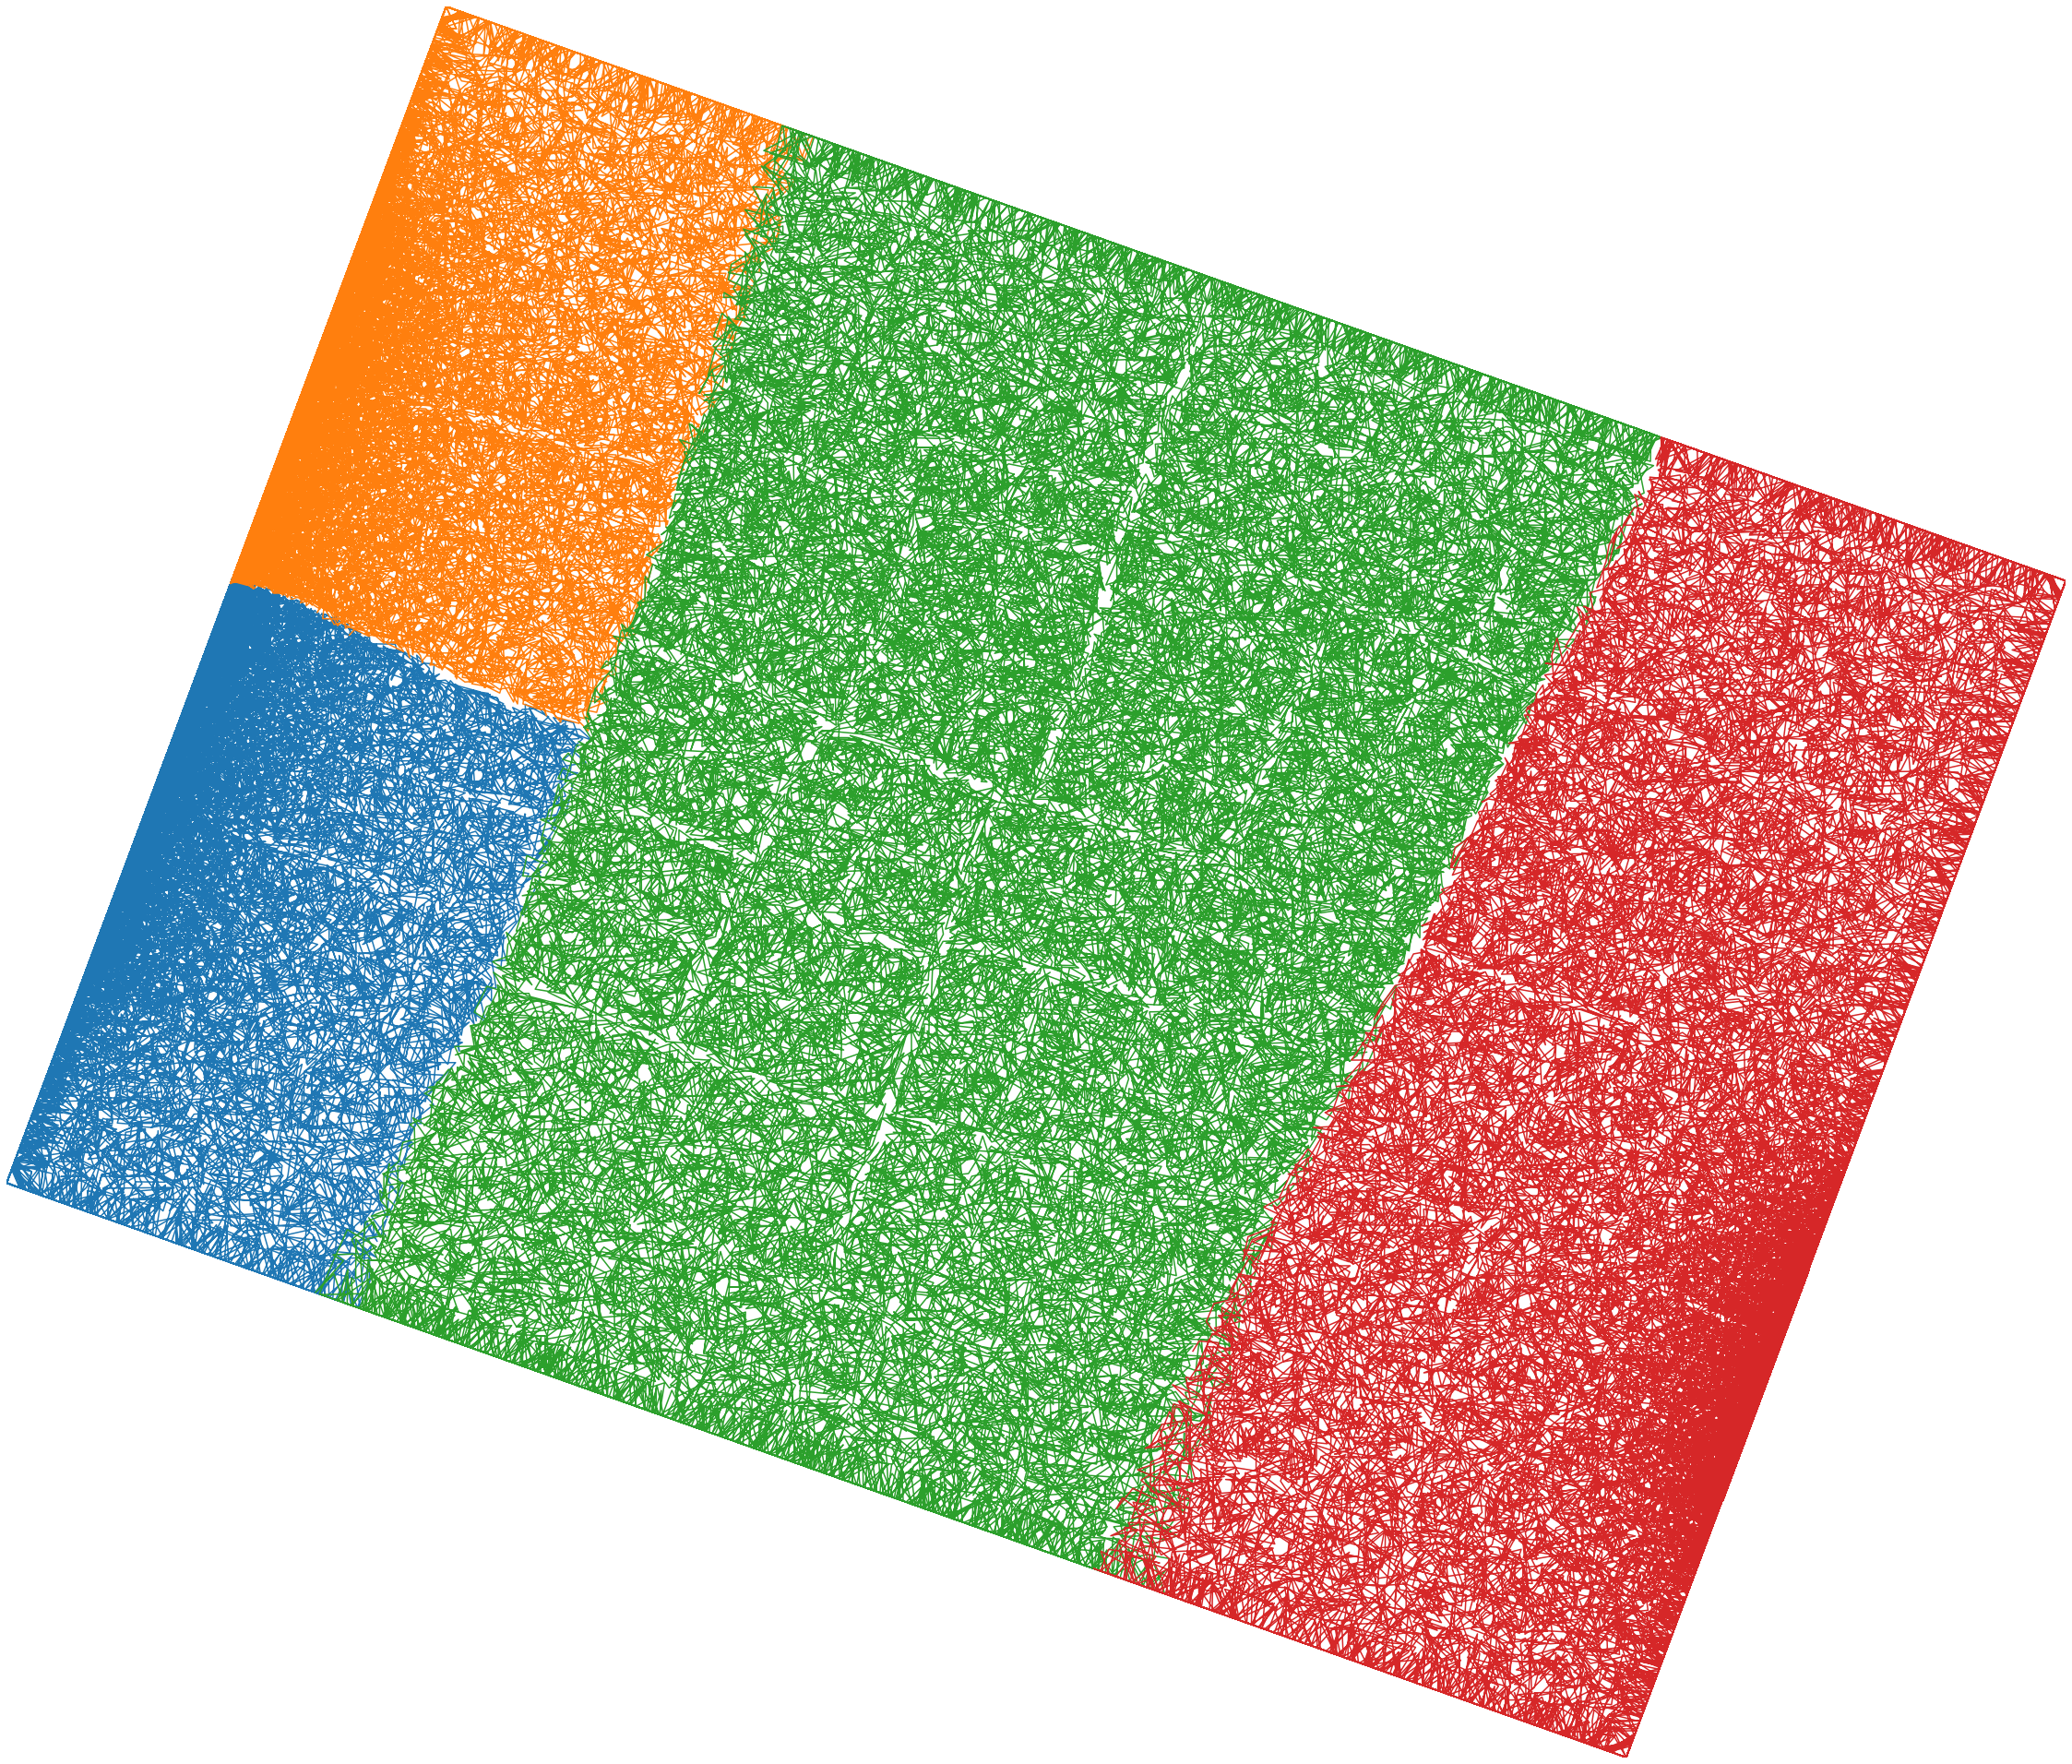

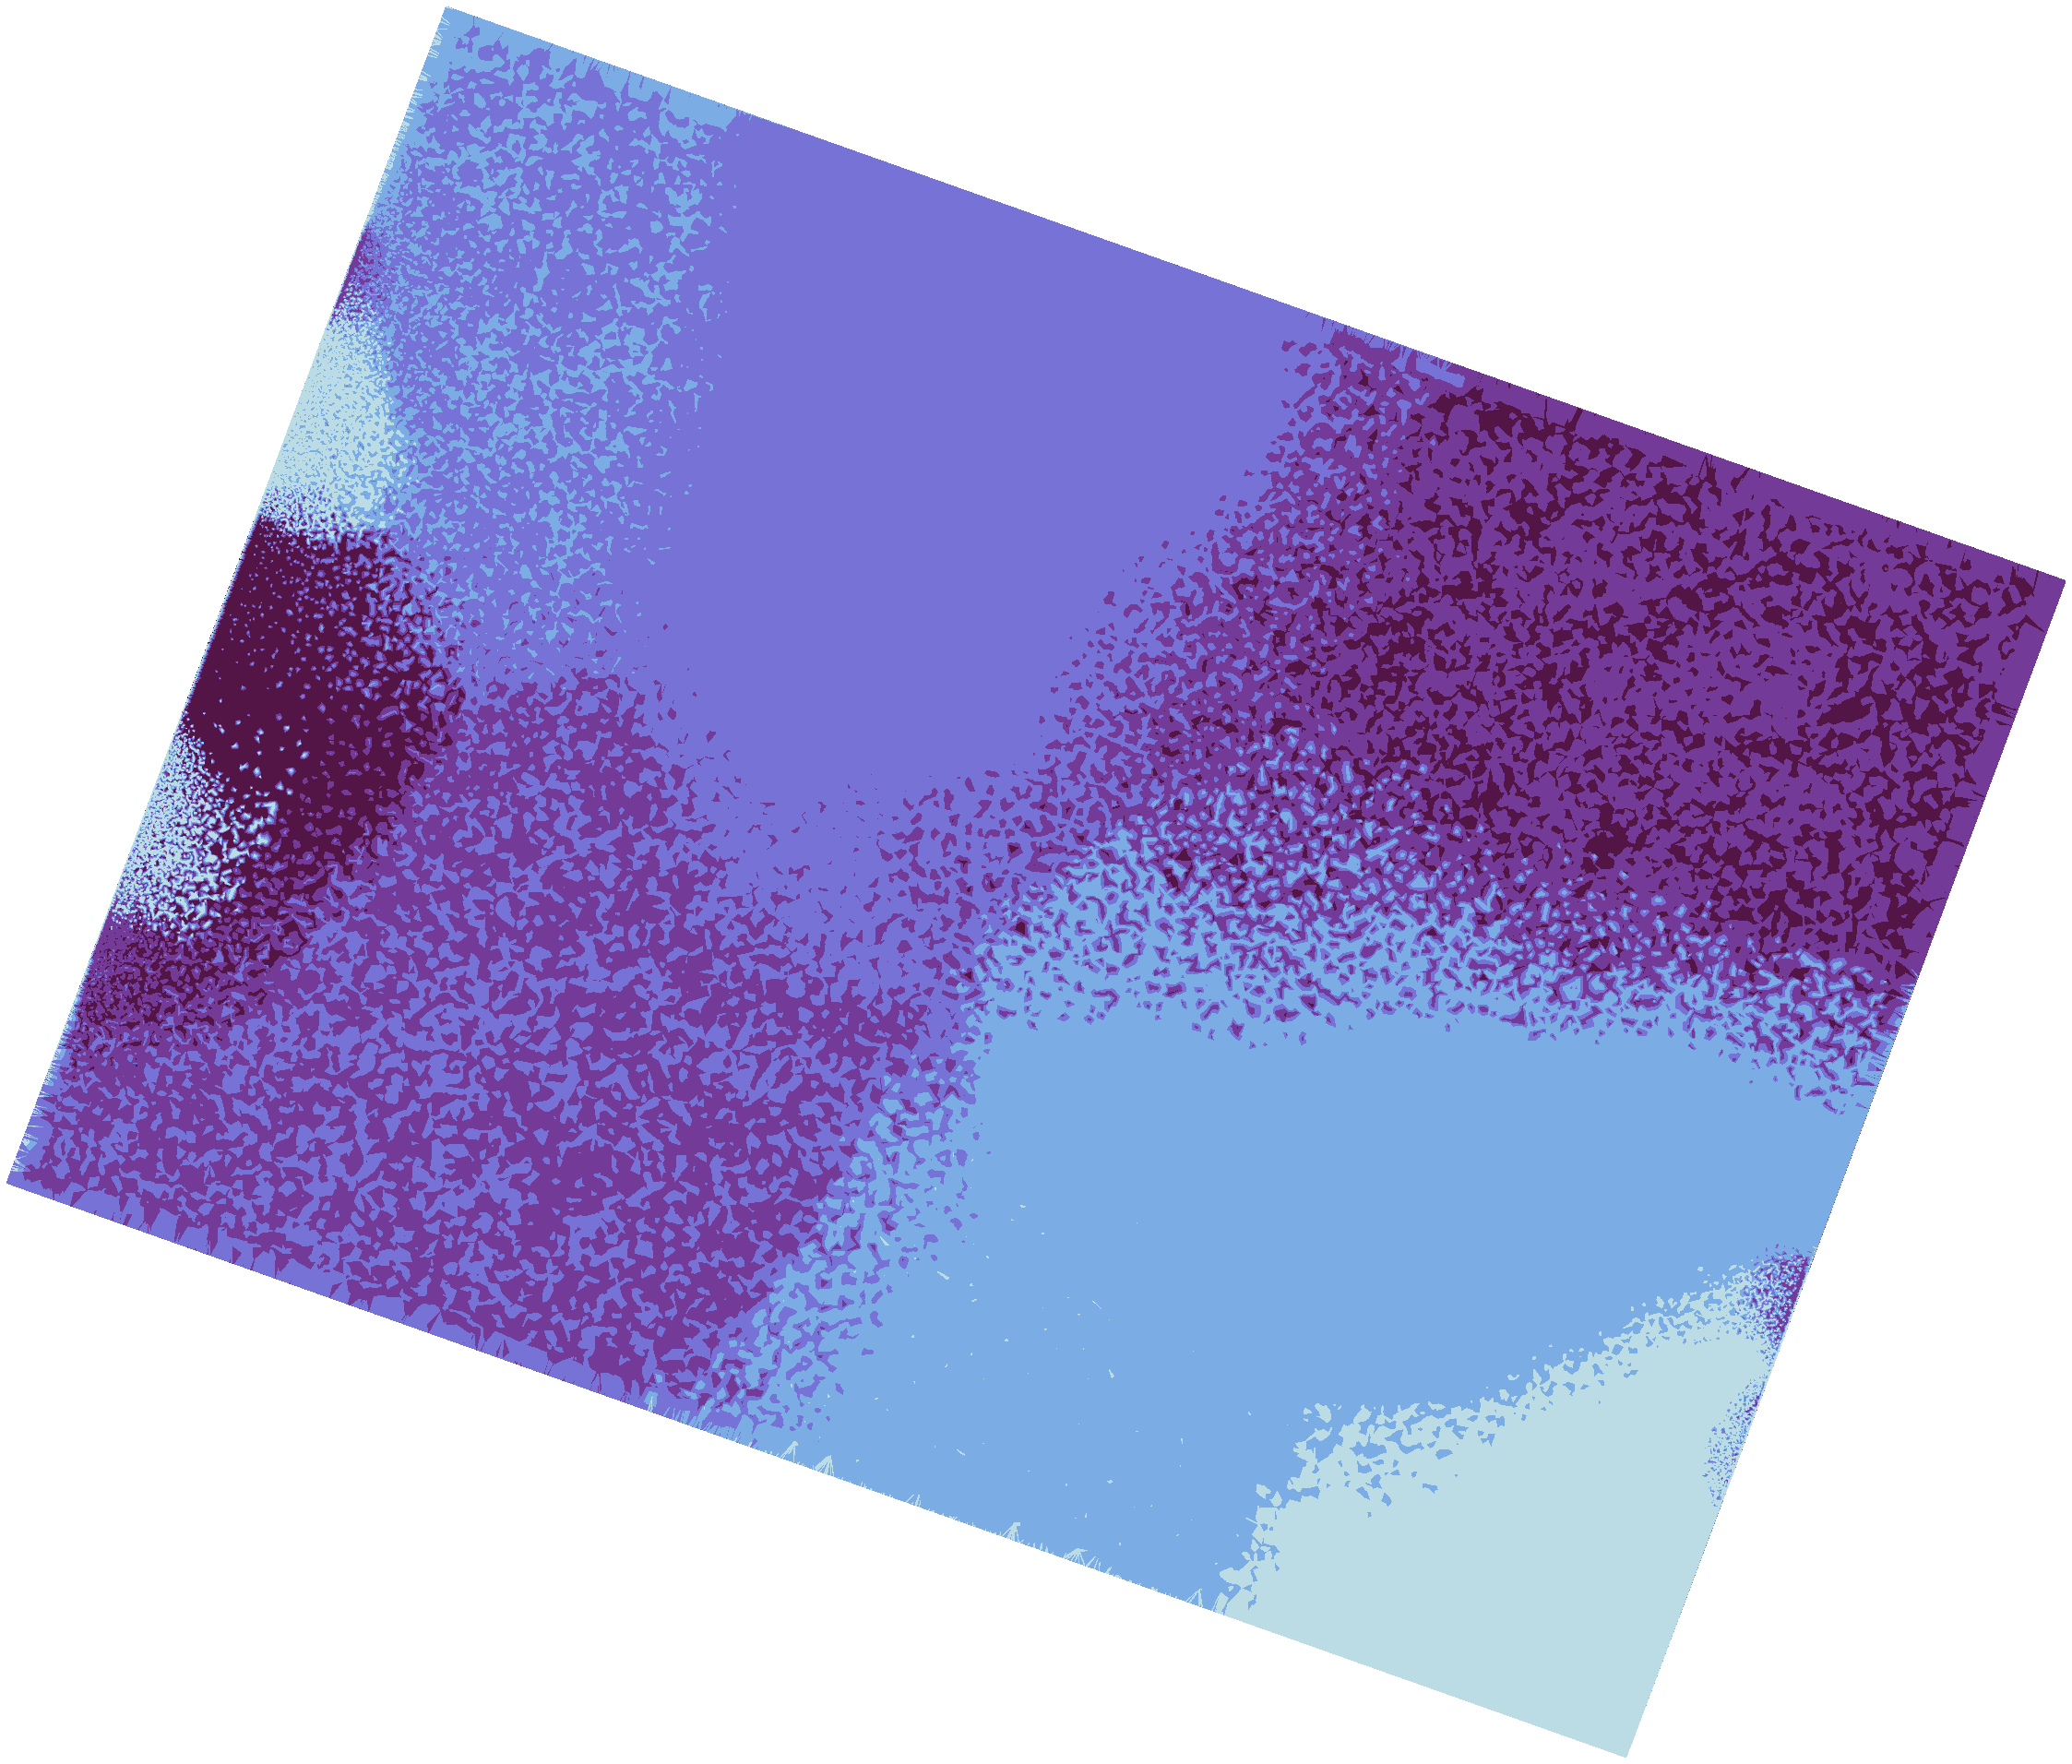

In [ ]:
import cmocean
plot_trace_vtu_2D(coords_vtu[space_filling_orderings[0]], 4)
countour_plot_vtu_2D(coords_vtu, 4, cmap = cmocean.cm.dense_r)

In [ ]:
print(full_tensor[0].shape, full_tensor.shape)

torch.Size([148906, 1]) torch.Size([455, 148906, 1])


In [ ]:
def index_split(train_ratio, valid_ratio, test_ratio, total_num = 500):
  if train_ratio + valid_ratio + test_ratio != 1:
    raise ValueError("Train,valid and test ratio together should be 1")
  total_index = np.arange(1, total_num + 1)
  rng = np.random.default_rng()
  total_index = rng.permutation(total_index)
  knot_1 = int(total_num * train_ratio)
  knot_2 = int(total_num * valid_ratio) + knot_1
  train_index, valid_index, test_index = np.split(total_index, [knot_1, knot_2])
  return train_index, valid_index, test_index

def normalize_tensor(tensor):
  if tensor.ndim > 2:
     t_mean = torch.zeros(tensor.shape[-1])
     t_std = torch.zeros(tensor.shape[-1])
     for i in range(tensor.shape[-1]):
        t_mean[i] = tensor[..., i].mean()
        t_std[i] = tensor[..., i].std()
        tensor[...,i] -= t_mean[i]
        tensor[...,i] /= t_std[i]
     return tensor, t_mean, t_std
  else:
      t_mean = torch.mean(tensor)
      t_std = torch.std(tensor)
      return (tensor - t_mean)/t_std, t_mean, t_std

def standardlisation(tensor, lower = -1, upper = 1):
  if tensor.ndim > 2:
     tk = torch.zeros(tensor.shape[-1])
     tb = torch.zeros(tensor.shape[-1])
     for i in range(tensor.shape[-1]):
        tk[i] = (upper - lower) /(tensor[..., i].max() - tensor[..., i].min())
        tb[i] = (tensor[..., i].max() * lower - tensor[..., i].min() * upper) /(tensor[..., i].max() - tensor[..., i].min())
        tensor[...,i] *= tk[i]
        tensor[...,i] += tb[i]
     return tensor, tk, tb
  else:
      tk = (upper - lower) / (tensor.max() - tensor.min())
      tb = (tensor.max() * lower - tensor.min() * upper) / (tensor.max() - tensor.min())
      return tensor * tk + tb, tk, tb

def destandardlisation(tensor, tk, tb):
    if tensor.ndim > 2:
       for i in range(tensor.shape[-1]):
           tensor[...,i] -= tb[i]
           tensor[...,i] /= tk[i]
    else:
        tensor -= tb
        tensor /= tk
    return tensor

In [ ]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1
train_index, valid_index, test_index = index_split(train_ratio, valid_ratio, test_ratio, total_num = full_tensor.shape[0])
print(train_index, valid_index, test_index)

full_set, k, b = standardlisation(full_tensor, lower = -1, upper = 1)

[325 324 424 172 251 300 315 245  79  64   4 310 454  69 374 304 156 163
 286 348 361 320  22  28 267 216 123  68 182  14 282 390 244 308 432 203
  88 293 280 148 194 204 455 209 249 213 104 274 141 317 227 409 229  89
 443 242  96 133 332 220 346 113 423  43 239  66 345  94 170 330 118  51
  74 384 106 240 336 449 357 259 221 416 413 301 257 217 353 328 201 128
 114  95  99  37 112 171 188  65 248  21 196 386 168 101 406 192  77 407
   9 321 176 439  91 295 269 278  60 444 102  55 401 337 207   2 292 277
 270 302 438 173 264 233 232 262 256  85 271  50 326 147  61 296 305 266
 272 356 150 307  46  29 183 322 152 445 285  11 167 236  42 334 154 369
 363  59  39  10 190 247 303  32 450  15 144 344 451 228  41 107 281 371
 222  84 143 184 211   7 110 116 341 335 347 191 146 212 339  71  36 430
 124 389 397 254 243 350  92 157 129 290 121 130  20 151 453 358 263 226
 319  76 179 125 414  34 403 452 370  33 261 206 193  31  63 375  75 316
 117 329 368 383  52   6  26  53 313 195 197 134 34

In [ ]:
k.detach().numpy()

array([0.00184219], dtype=float32)

In [ ]:
b.detach().numpy()

array([-1.730393], dtype=float32)

In [ ]:
train_set = full_set[train_index - 1]
valid_set = full_set[valid_index - 1]
test_set = full_set[test_index - 1]
print('train_set: ',train_set.shape)
print(train_set)

train_set:  torch.Size([364, 148906, 1])
tensor([[[-0.9805],
         [-0.9870],
         [-0.9713],
         ...,
         [ 0.8888],
         [ 0.8225],
         [ 0.8662]],

        [[-0.9808],
         [-0.9871],
         [-0.9718],
         ...,
         [ 0.8868],
         [ 0.8190],
         [ 0.8625]],

        [[-0.9923],
         [-0.9929],
         [-0.9911],
         ...,
         [ 0.7014],
         [ 0.4174],
         [ 0.5341]],

        ...,

        [[-0.9934],
         [-0.9934],
         [-0.9935],
         ...,
         [ 0.4608],
         [-0.9602],
         [-0.8923]],

        [[-0.7607],
         [-0.7790],
         [-0.6383],
         ...,
         [ 0.9146],
         [ 0.8979],
         [ 0.9102]],

        [[-0.9115],
         [-0.9478],
         [-0.8620],
         ...,
         [ 0.9148],
         [ 0.9124],
         [ 0.9141]]])


In [ ]:
from sklearn.decomposition import PCA

# p_tot -> proportion of the variance we want to keep
p = 0.999
p_tot = 0.9999999999999995
# Create an instance of the PCA model
# pca = PCA(n_components=all_values.shape[0])
time0 = time.time()
pca = PCA(p_tot)
all_value = train_set.detach().numpy()
all_value = all_value.reshape((all_value.shape[0],all_value.shape[1]))
print(all_value, all_value.shape)
train_pca = pca.fit_transform(all_value)
time1 = time.time()
#
print(train_pca.shape)
print('Computational time of PCA', time1-time0)
# In this case np.allclose == true because we are not 
# reducing the dimensionality
X_recovered = pca.inverse_transform(train_pca)
np.allclose(X_recovered, all_value)
print(X_recovered)

[[-0.9804994  -0.9869578  -0.9713453  ...  0.8888458   0.82247865
   0.8662394 ]
 [-0.9807573  -0.98705524 -0.9717933  ...  0.8868183   0.8190409
   0.8624724 ]
 [-0.992348   -0.99291223 -0.99107575 ...  0.701409    0.41744244
   0.5340828 ]
 ...
 [-0.99340045 -0.9934301  -0.993463   ...  0.46084988 -0.96016324
  -0.8922742 ]
 [-0.76071763 -0.77897936 -0.63831365 ...  0.91457593  0.8979093
   0.9102081 ]
 [-0.91147125 -0.9477817  -0.8620035  ...  0.91475856  0.91244686
   0.9141425 ]] (364, 148906)
(364, 313)
Computational time of PCA 7.773507118225098
[[-0.98042357 -0.9869679  -0.9712683  ...  0.8888379   0.82252693
   0.866246  ]
 [-0.98046815 -0.9870646  -0.9716111  ...  0.8868623   0.81911564
   0.8625051 ]
 [-0.99165815 -0.9929117  -0.99098766 ...  0.7013952   0.4175095
   0.5340536 ]
 ...
 [-0.99345136 -0.99342024 -0.99330014 ...  0.4609009  -0.96014524
  -0.8923215 ]
 [-0.7606825  -0.77895856 -0.6382935  ...  0.9145778   0.8979126
   0.91019887]
 [-0.9114274  -0.94779205 -0.8619

In [ ]:
#train_pca = train_pca.reshape((train_pca[0],train_pca[1],1))
train_pca = train_pca.reshape(train_pca.shape + (1,))
train_pca.shape


(364, 313, 1)

In [ ]:
training_data = np.zeros((nTrain,nNodes,4))
for i in range(nTrain):
  data = np.loadtxt('csv_data/data_' +str(i)+ '.csv', delimiter=',')
  training_data[i,:,:] = data
training_data = np.array(training_data)
print('size training data', training_data.shape)

valid_data = np.zeros((nValid,nNodes,4))
for i in range(nTrain,nTrain+nValid):
  data = np.loadtxt('csv_data/data_' +str(i)+ '.csv', delimiter=',')
  valid_data[i-nTrain,:,:] = data
valid_data = np.array(valid_data)
print('size validation data', valid_data.shape)

test_data = np.zeros((nTest,nNodes,4))
for i in range(nTrain+nValid,nTrain+nValid+nTest):
  data = np.loadtxt('csv_data/data_' +str(i)+ '.csv', delimiter=',')
  test_data[i-nTrain-nValid,:,:] = data
test_data = np.array(test_data)
print('size test data', test_data.shape)


t_read_1 = time.time(

size training data (200, 148906, 4)
size validation data (25, 148906, 4)
size test data (25, 148906, 4)


"\n########################################################################################\n# rescale the data so that u and v data lies in the range [-1,1] (and speed in [0,1])\nma = np.max(training_data[:, :, 2])\nmi = np.min(training_data[:, :, 2])\nk = 1./(ma - mi)\nb = 1 - k*ma #k*mi\ntraining_data[:, :, 2] = k * training_data[:, :, 2] + b #- b\n# this won't be used\n\nma = np.max(training_data[:, :, 3])\nmi = np.min(training_data[:, :, 3])\nku = 2./(ma - mi)\nbu = 1 - ku*ma \ntraining_data[:, :, 3] = ku * training_data[:, :, 3] + bu\nvalid_data[:, :, 3] = ku * valid_data[:, :, 3] + bu\ntest_data[:, :, 3] = ku * test_data[:, :, 3] + bu\n\nma = np.max(training_data[:, :, 4])\nmi = np.min(training_data[:, :, 4])\nkv = 2./(ma - mi)\nbv = 1 - kv*ma\ntraining_data[:, :, 4] = kv * training_data[:, :, 4] + bv\nvalid_data[:, :, 4] = kv * valid_data[:, :, 4] + bv\ntest_data[:, :, 4] = kv * test_data[:, :, 4] + bv\n\n#########################################################################

# Covolutional autoencoder (CAE) <a name='first-bullet'></a>

## set device for the usage of GPU

In [103]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
  print("Cuda installed! Running on GPU!")
  device = 'cuda'
else:
  print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
joblib.dump(training_data, 'training_data.pkl')
joblib.dump(valid_data, 'valid_data.pkl')
joblib.dump(test_data, 'test_data.pkl')

['test_data.pkl']

In [104]:
# load training, validation and test dataset
training_data = joblib.load("training_data.pkl")
valid_data = joblib.load("valid_data.pkl") 
test_data = joblib.load("test_data.pkl") 

In [105]:
training_data.shape

(200, 148906, 4)

In [109]:
ma = np.max(training_data[:, :, 3])
mi = np.min(training_data[:, :, 3])
ku = 2/(ma - mi)
bu = 1 - ku*ma
training_data[:, :, 3] = ku * training_data[:, :, 3] + bu
valid_data[:, :, 3] = ku * valid_data[:, :, 3] + bu

In [110]:
training_data[:, :, 3]

array([[ 0.91489822,  0.91489822,  0.91489822, ...,  0.91489822,
         0.91489822,  0.91489822],
       [ 0.88968423,  0.89779732,  0.87729678, ...,  0.85474053,
        -0.99583015, -0.98834312],
       [ 0.56643435, -0.17159656, -0.41022345, ...,  0.78753832,
        -0.9958238 , -0.98714501],
       ...,
       [-0.98226497, -0.98913833, -0.96935692, ...,  0.91410667,
         0.89976436,  0.90323815],
       [-0.97837386, -0.98609403, -0.96187901, ...,  0.91404334,
         0.88674411,  0.89467007],
       [-0.97446665, -0.98298228, -0.95391613, ...,  0.91400185,
         0.8732878 ,  0.88730931]])

In [117]:
print('python version', platform.python_version())
print('torch version', torch.__version__)
print('numpy version', np.version.version)

#train_set = torch.tensor()
#train_set = train_pca
#training_data = train_set
#valid_data = valid_set
#test_data = test_set
#cat /usr/local/cuda/version.txt

########################################################################################
t_read_0 = time.time()

# read in the data (1000 csv files)
nTrain = 800
nValid = 100
nTest = 100
nNodes = 148906 # should really work this out

# [:, :, 2] is speed, [:, :, 3] is u, [:, :, 4] is v
# (speed not really needed)
# [:, :, 0] and [:, :, 1] are the SFC orderings


########################################################################################
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 128 latent variables
print("compress to 128")
torch.manual_seed(42)

########################################################################################
# Hyper-parameters
EPOCH = 5000
BATCH_SIZE = 32
LR = 0.0001
weight_sp = 0.33
########################################################################################

k = nNodes # number of nodes - this has to match training_data.shape[0]
print('training_data.shape: ',training_data.shape) # nTrain by number of nodes by 5
# (200, 148906, 4)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)


class CNN(nn.Module):
    '''
    torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, 
    padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            
            linear: 
            in_features – size of each input sample
            out_features – size of each output sample
    
    Transpose1d output size:
    Lout=(Lin−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1
    
    '''
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder_h1 = nn.Sequential(
          # input shape (b, 1, 148906)
          #nn.LeakyReLU(),
          nn.Tanh(),
          #torch.tanh(),
          nn.Conv1d(1, 16, 32, 4, 16),
          # output shape (b, 4, 37227)
          #torch.tanh(),
          #nn.LeakyReLU(),
          nn.Tanh(),
          # activation
          nn.Conv1d(16, 16, 32, 4, 16),
          # output shape (b, 8,9307)
          #torch.tanh(),
          #nn.LeakyReLU(),
          nn.Tanh(),
          # activation
          nn.Conv1d(16, 16, 32, 4, 16),
          # output shape (b, 16, 2327)
          #torch.tanh(),
          #nn.LeakyReLU(),
          nn.Tanh(),
          # activation
          nn.Conv1d(16, 16, 32, 4, 16),
          # output shape (b, 32, 582)
          #torch.tanh(),
          nn.Tanh(),
          #nn.LeakyReLU(),

          # added one more layer 
          nn.Conv1d(16, 16, 32, 4, 16),
          # output shape (b, 32, 145)
          #torch.tanh(),
          nn.Tanh(),
          #nn.LeakyReLU(),
          # activation
        )
        self.fc1 = nn.Sequential(
            
            nn.Linear(2336, 128),
            nn.Tanh(),
            #nn.LeakyReLU(),
            #torch.tanh(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 2336),
            nn.Tanh(),
            #torch.tanh(),
            #nn.LeakyReLU(),
        )
        self.decoder_h1 = nn.Sequential(
            # (b, 16, 145)
            #nn.LeakyReLU(),
            nn.Tanh(),
            # add one more layer
            nn.ConvTranspose1d(16, 16, 32, 4, 15), # (b, 8, 582)
            #nn.LeakyReLU(),
            nn.Tanh(),
            #torch.tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 14), # (b, 8, 2328)
            #torch.tanh(),
            nn.Tanh(),
            #nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 16, 32, 4, 16), # (b, 4, 9308)
            nn.Tanh(),
            #torch.tanh(),
            #nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 16, 32, 4, 16), # (b, 2, 37228)
            nn.Tanh(),
            #torch.tanh(),
            #nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 1, 32, 4, 17), # (b, 1, 148906)
            #torch.tanh(),
            nn.Tanh(),
            #nn.LeakyReLU(),
        )
        
        # input sparse layers, initialize weight as 0.33, bias as 0
        self.weight1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight1_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight1_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight11 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight11_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight11_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias11 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight2 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight2_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight2_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight22 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight22_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight22_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias22 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight3 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight3_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight3_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias3 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.zeros(k)),requires_grad = True)
        self.weight33 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight33_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight33_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias33 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.zeros(k)),requires_grad = True)
        self.weight4 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight4_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight4_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias4 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.zeros(k)),requires_grad = True)
        self.weight44 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight44_0 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.weight44_1 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.ones(k)),requires_grad = True)
        self.bias44 = torch.nn.Parameter(torch.FloatTensor(weight_sp * torch.zeros(k)),requires_grad = True)
        
        # output sparse layers, initialize weight as 0.5, bias as 0
        self.weight_out1 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out1_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out1_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out11 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out11_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out11_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out2 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out22 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out3 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out33 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out4 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out44 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.bias_out1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.bias_out2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)


    def forward(self, x):

        '''
        x[:, :, 0] is SFC index
        x[:, :, 1] is SFC index
        x[:, :, 3] is CO2_ppm after standlisation
        '''
          # first curve
        # 16, 148906, 1
        ToSFC1 = x[:, :, 0] # sfc indices
        ToSFC1Up = torch.zeros_like(ToSFC1)
        ToSFC1Down = torch.zeros_like(ToSFC1)
        ToSFC1Up[:-1] = ToSFC1[1:]
        ToSFC1Up[-1] = ToSFC1[-1]
        ToSFC1Down[1:]=ToSFC1[:-1]
        ToSFC1Down[0]=ToSFC1[0]
        #print('x: ',x, x.shape)
        batch_num = ToSFC1.shape[0]
        #print('batch_num: ',batch_num)
        #print("ToSFC1: ",ToSFC1, ToSFC1.shape) # (16, 20550)
        #x1 = x[:, :, 3:5] # u and v
        x1 = x[:,:,3:4] # CO2
        #print('x1:',x1[0, :, 0])
        #print("x1", x1.shape) # ([16, 148906, 1])
        #print('#x1 = x[:, :, 3:5] shape:',x[:, :, 3:5].shape) # u and v
        x1_1d = torch.zeros((batch_num, 1, k)).to(device) # ([16, 1, 148906])
        #print('shape:', x1_1d.shape)
        #print('x11d index: ', x1_1d[0, 0, :])
        #print('x1 index:',x1[1, :, 0])
        #print('x1_1d: ',x1_1d)
        #print('try: ',x1_1d[0, 0, :])
        #print('try [1, :, 0]: ', x1_1d[1, :, 0])
        #print('x11d:',x1_1d[0, 2, :])
        #print('x1:',x1[0, :, 1])
        # first input sparse layer, then transform to sfc order1
        for j in range(batch_num):
            x1_1d[j, 0, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight1 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight1_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight1_1 + self.bias1
        
            #x1_1d[j, 1, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight11 + \
            #                 x1[j, :, 0][ToSFC1Up[j].long()] * self.weight11_0 + \
            #                 x1[j, :, 0][ToSFC1Down[j].long()] * self.weight11_1 + self.bias11

            #x1_1d[j, 2, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight2 + \
            #                 x1[j, :, 0][ToSFC1Up[j].long()] * self.weight2_0 + \
            #                 x1[j, :, 0][ToSFC1Down[j].long()] * self.weight2_1 + self.bias2

            #x1_1d[j, 3, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight22 + \
            #                 x1[j, :, 0][ToSFC1Up[j].long()] * self.weight22_0 + \
            #                 x1[j, :, 0][ToSFC1Down[j].long()] * self.weight22_1 + self.bias22

        # first cnn encoder
        encoded_1 = self.encoder_h1(x1_1d.view(-1, 1, k)) #(16, 16, 146)
        #print("encoded_1", encoded_1.shape)
        # flatten and concatenate
        #encoded_3 = encoded_1.view(-1,1296)
        encoded_3 = encoded_1.view(-1,2336)

        #print("encoded_3", encoded_3.shape)
        # fully connection
        encoded = self.fc1(encoded_3) # ([16, 128])
        #print("encoded", encoded.shape)
        decoded_3 = self.decoder_h1(self.fc2(encoded).view(-1, 16, 146))
        #print("decoded_3", decoded_3.shape) # [16, 4, 148906]

        BackSFC1 = torch.argsort(ToSFC1)
        BackSFC1Up = torch.argsort(ToSFC1Up)
        BackSFC1Down = torch.argsort(ToSFC1Down)

        decoded_sp = torch.zeros((batch_num, k, 1)).to(device)
        # output sparse layer, resort according to sfc transform
        for j in range(batch_num):
            decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
                                  decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
                                  decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1
            #print('decoded3: ',decoded_3[j, 0, :])


            #decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
            #                      decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
            #                      decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1 + \
            #                      decoded_3[j, 1, :][BackSFC1[j].long()]* self.weight_out11 + \
            #                     decoded_3[j, 1, :][BackSFC1Up[j].long()] * self.weight_out11_0 + \
            #                      decoded_3[j, 1, :][BackSFC1Down[j].long()] * self.weight_out11_1 + self.bias_out1

            #decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
            #                      decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
            #                      decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
            #                      decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
            #                     decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
            #                    decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2 

            #decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
            #                      decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
            #                      decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
            #                      decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
            #                     decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
            #                     decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2 
        
        # resort 1D to 2D
        decoded = F.tanh(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        #decoded = F.leaky_relu(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        return encoded, decoded


python version 3.7.11
torch version 1.9.0+cu102
numpy version 1.19.5
compress to 128
training_data.shape:  (200, 148906, 4)


In [118]:
########################################################################################
# train the autoencoder

t_train_0 = time.time()

autoencoder = CNN().to(device)
#autoencoder = torch.load("./UnstructuredNeigh128_200.pkl")
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

loss_list = []
loss_valid = []
for epoch in range(EPOCH):
  for step, x in enumerate(train_loader):
    #print("x", x.shape)
    b_y = x[:, :,3:4].to(device)
    #print('b_y: ',b_y,b_y.shape)

    # b_x is whole matrix
    b_x = x.to(device)
    #print("b_x: ",b_x, b_x.shape)

    encoded, decoded = autoencoder(b_x.float())

    loss = loss_func(decoded, b_y.float())  # mean square error
    optimizer.zero_grad()             # clear gradients for this training step
    loss.backward()                # backpropagation, compute gradients
    optimizer.step()               # apply gradients

  loss_list.append(loss)
  #print('what is the shape: ',decoded.shape, b_y.shape)
  encoded, decoded = autoencoder(torch.tensor(valid_data).to(device))
  error_autoencoder = (decoded.detach() - torch.tensor(valid_data[:,:, 3:4]).to(device))
  MSE_valid = (error_autoencoder**2).mean()
  loss_valid.append(MSE_valid)

  print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), '| valid loss: %.6f' % MSE_valid)

  # save the weights every 100 epochs 
  #if (epoch%100 == 0):
  #  torch.save(autoencoder, 'OneNeigh128_'+str(epoch)+'.pkl')




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


流式输出内容被截断，只能显示最后 5000 行内容。
Epoch:  0 | train loss: 0.616232 | valid loss: 0.572225
Epoch:  1 | train loss: 0.618808 | valid loss: 0.572447
Epoch:  2 | train loss: 0.578503 | valid loss: 0.572643
Epoch:  3 | train loss: 0.590215 | valid loss: 0.572658
Epoch:  4 | train loss: 0.612361 | valid loss: 0.572054
Epoch:  5 | train loss: 0.595555 | valid loss: 0.569564
Epoch:  6 | train loss: 0.591046 | valid loss: 0.562295
Epoch:  7 | train loss: 0.584990 | valid loss: 0.545817
Epoch:  8 | train loss: 0.536825 | valid loss: 0.518651
Epoch:  9 | train loss: 0.469883 | valid loss: 0.486391
Epoch:  10 | train loss: 0.470676 | valid loss: 0.454009
Epoch:  11 | train loss: 0.415763 | valid loss: 0.422722
Epoch:  12 | train loss: 0.406315 | valid loss: 0.396853
Epoch:  13 | train loss: 0.396523 | valid loss: 0.375098
Epoch:  14 | train loss: 0.376075 | valid loss: 0.359732
Epoch:  15 | train loss: 0.390873 | valid loss: 0.351061
Epoch:  16 | train loss: 0.348888 | valid loss: 0.345385
Epoch:  17 | t

In [85]:
train_reconstruct = autoencoder.to('cpu')(torch.tensor(training_data).to('cpu'))

RuntimeError: ignored

In [113]:
valid_data[:, :, 3].reshape(25,148906).shape

(25, 148906)

In [114]:
encoded, decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
error_autoencoder = decoded.cpu().detach().numpy() - valid_data[:, :, 3].reshape((25,148906))
print("Mse_err", (error_autoencoder**2).mean())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


ValueError: ignored

In [119]:
t_train_1 = time.time()

########################################################################################
# save training and validation loss
losses_combined = np.zeros((EPOCH,2))
losses_combined[:,0] = np.asarray(loss_list)
losses_combined[:,1] = np.asarray(loss_valid)
np.savetxt('losses.csv', losses_combined , delimiter=',')

########################################################################################
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()

encoded, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
#error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
#print("MSE_err of training data", (error_autoencoder**2).mean())

encoded, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
#error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
#print("Mse_err of validation data", (error_autoencoder**2).mean())

encoded, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
#error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
#print("Mse_err of test data", (error_autoencoder**2).mean())

#print("Shape of training, valid, test after decoding", training_decoded.shape, valid_decoded.shape, test_decoded.shape)

########################################################################################
# rescale results
training_decoded[:, :, 0] = (training_decoded[:, :, 0] - bu)/ku
valid_decoded[:, :, 0] = (valid_decoded[:, :, 0] - bu)/ku
test_decoded[:, :, 0] = (test_decoded[:, :, 0] - bu)/ku

#training_decoded[:, :, 1] = (training_decoded[:, :, 1] - bv)/kv
#valid_decoded[:, :, 1] = (valid_decoded[:, :, 1] - bv)/kv
#test_decoded[:, :, 1] = (test_decoded[:, :, 1] - bv)/kv

results = np.concatenate((training_decoded.cpu().data.numpy(), valid_decoded.cpu().data.numpy(), test_decoded.cpu().data.numpy()))
##results = np.concat(training_data, valid_data)
print('results shape', results.shape)
N = results.shape[1] * results.shape[2]
results = results.reshape((results.shape[0],N), order='F')
print('results shape', results.shape, type(results))

## write results to file
#np.savetxt('results.csv', results , delimiter=',')

t_predict_1 = time.time()

print("Total time taken          :", t_predict_1 - t_read_0, "seconds")
print("time training autoencoder :", t_train_1   - t_train_0, "seconds")
print("time predicting           :", t_predict_1 - t_predict_0, "seconds")
print("Ending...")

######################################################################################

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


results shape (250, 148906, 1)
results shape (250, 148906) <class 'numpy.ndarray'>
Total time taken          : 7603.2616856098175 seconds
time training autoencoder : 7599.688317775726 seconds
time predicting           : 0.9877607822418213 seconds
Ending...


(5000, 2)
(5000,)
5000


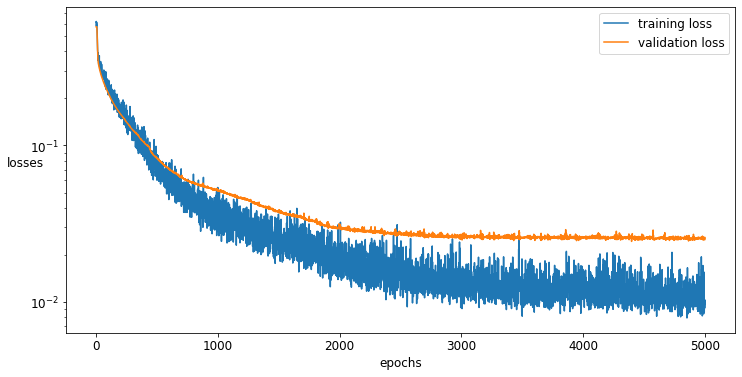

In [120]:
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'font.family':'sans-serif'})
# rc('font',**{'family':'serif','serif':['Times']})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rc('axes', labelsize=12)

data = np.loadtxt('losses.csv',delimiter=',')
n_epochs = data.shape[0]
epochs = np.linspace(1,n_epochs,n_epochs)

print(data.shape)
print(epochs.shape)
print(n_epochs)

plt.figure(figsize=(12,6))
plt.plot(epochs,data[:,0],label='training loss')
plt.plot(epochs,data[:,1],label='validation loss')
plt.yscale('log')
plt.ylabel('losses',  rotation='horizontal')
plt.xlabel('epochs')
plt.legend()
#plt.savefig('losses_one_curve_to_128.png')
plt.show()

## Train, validation and test in another way

In [ ]:
!pip install livelossplot

In [ ]:
from structured import *
from training import *
from util import *
from sfc_cae import *

In [ ]:
print('input size:')
train_set.shape[1]

input size:


148906

### Indicate the parameters for the **autoencoder**

`input_size` is the number of Node, for example 20550 <br> `dimension` is the dimension of the data in Vtu file, 2 or 3.<br> `components` is the number of components you are compressing, if the tensor is 2 dimension, then it's default of 1. `self_concat` is chennel copying operation, you could keep it default as 1, or 2 when you have multiple SFCs. <br> `structured`: bool, whether you are training SFC-CAE on a structured mesh or not.<br>`nearest_neighboring`: bool, adding sparse layers or not, suggest to turn on.<br>
`dims_letent`: The dimension of the compressed data after applying decoder. <br>
`space_filling_orderings`, `invert_space_filling_orderings` : lists of sfc\inverse_sfc nums, generated by `get_sfc_curves_from_coords` function, or read the orderings from a `csv` file on your own. <br>
`activation`: Can be customly defined, but if you not spcify, the activation would be `ReLU()` for structured mesh, and `Tanh()` for unstructured mesh.

In [ ]:
input_size = train_set.shape[1]
dimension = 2
if train_set.ndim == 2: components = 1
else: components = train_set.shape[-1]
self_concat = 1
structured = False
nearest_neighbouring = True # shut down this may lead to a slightly poorer performance, but a quicker training spped
dims_latent = 4
activation = nn.Tanh()

In [ ]:
autoencoder = SFC_CAE(input_size,
             dimension,
             components,
             structured,
             self_concat,
             nearest_neighbouring,
             dims_latent,
             space_filling_orderings, 
             invert_space_filling_orderings,
             activation)

In [ ]:
autoencoder.output_structure()

The LaTeX script for the table structure of the SFC-CAE has been written to 'LatexTable.txt', please copy it to a LaTeX compiler environment, e.g. overleaf.


In [ ]:
batch_size = 16
seed = 41
lr = 3e-4
n_epochs = 100
weight_decay = 0
criterion_type = 'MSE'
valid_batch_size = valid_set.shape[0]
test_batch_size = test_set.shape[0]

'''
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)
'''

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=valid_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=True)

In [ ]:
print(train_loader.dataset.shape)

torch.Size([364, 148906, 1])


In [ ]:
autoencoder = train_model(autoencoder, 
               train_loader = train_loader,
               valid_loader = valid_loader,
               test_loader = test_loader,
               n_epochs = n_epochs, 
               lr = lr,
               weight_decay = weight_decay,
               criterion_type = criterion_type,
               seed = seed)

torch device num: 1 



RuntimeError: ignored

In [ ]:
test_reconstruct = autoencoder.to('cpu')(test_set)
print('test MSE loss: %e' % nn.MSELoss()(test_set, test_reconstruct).item())

# Standardise Data

The article below recommended standardising but it may not be necessary